In [13]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib as plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import argrelextrema

In [19]:


# Load data and preprocess
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')


# Load data and reverse to chronological order (oldest first)
df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')#.iloc[::-1].reset_index(drop=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Compute ATR30 for volatility scaling
df['prev_close'] = df['close'].shift(1)
df['TR'] = np.maximum(
    df['high'] - df['low'],
    np.abs(df['high'] - df['prev_close']),
    np.abs(df['low'] - df['prev_close'])
)
df['ATR30'] = df['TR'].rolling(30).mean()
df['volatility_threshold'] = 0.5 * df['ATR30']

# Label each point based on next 15 days
labels = []
for i in range(len(df) - 15):
    window = df['close'].iloc[i:i+16]  # Current + next 15 days
    current_close = window.iloc[0]
    future_close = window.iloc[-1]
    threshold = df['volatility_threshold'].iloc[i]
    
    # Linear regression slope and p-value
    x = np.arange(len(window))
    slope, _, _, p_value, _ = linregress(x, window)
    
    # Classification
    if (future_close >= current_close * (1 + threshold)) and (slope > 0) and (p_value < 0.05):
        labels.append('upward')
    elif (future_close <= current_close * (1 - threshold)) and (slope < 0) and (p_value < 0.05):
        labels.append('downward')
    else:
        labels.append('stable')

# Pad last 15 rows with NaN (no future data)
labels.extend([np.nan] * 15)
df['state'] = labels

# Output
print(df[['timestamp', 'close', 'state']].dropna())

     timestamp    close   state
0      01:00.4  0.00285  stable
1      00:36.9  0.00302  stable
2      00:13.3  0.00303  stable
3      59:49.8  0.00300  stable
4      59:26.2  0.00300  stable
...        ...      ...     ...
2023   59:53.9  0.32434  stable
2024   59:30.3  0.33644  stable
2025   59:06.8  0.33955  stable
2026   00:54.3  0.32206  stable
2027   00:30.7  0.29470  stable

[2028 rows x 3 columns]


<AxesSubplot:>

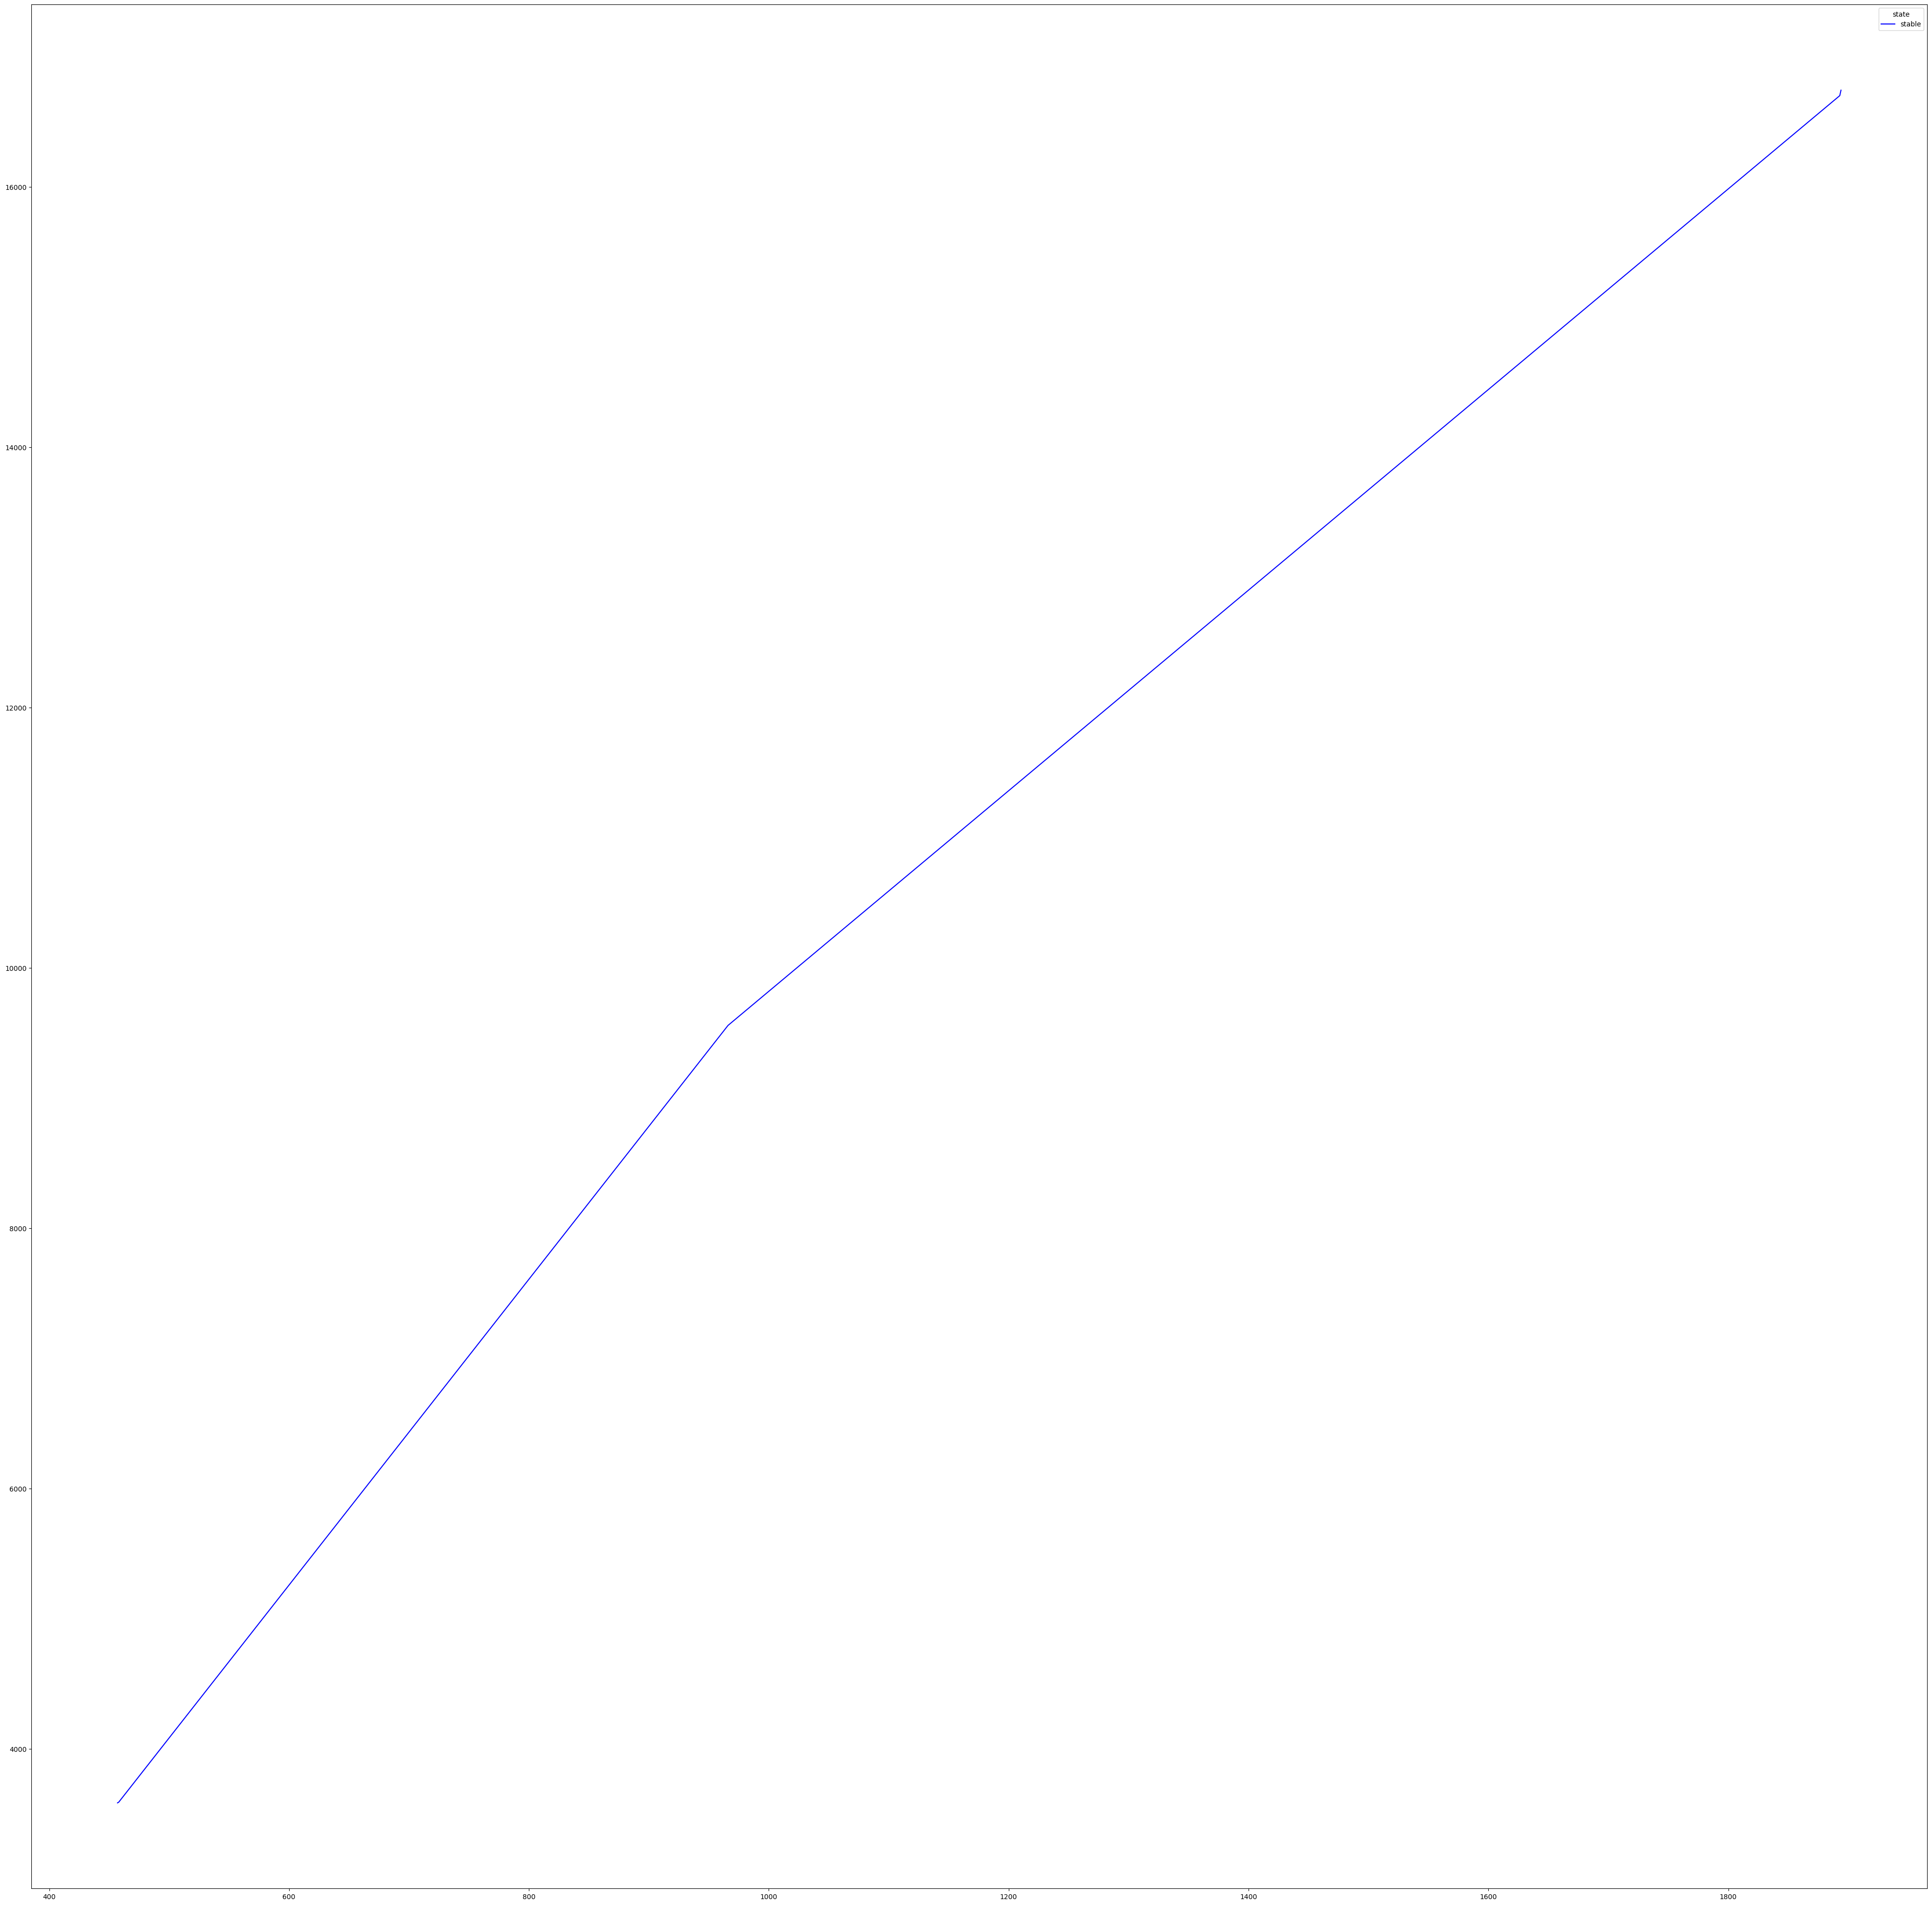

In [41]:


graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'b',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

In [38]:
#perplexity



def label_strict_states(df, price_col='close', min_run=10, max_run=200, tol=0.25, stable_mult=1.25):
    prices = df[price_col].to_numpy()
    n = len(prices)
    state = np.full(n, np.nan, dtype=object)
    recent_vol = pd.Series(prices).rolling(window=30, min_periods=10).std().to_numpy()

    extrema_idx = set()
    for order in range(min_run, max_run+1):
        min_idx = argrelextrema(prices, np.less_equal, order=order)[0]
        max_idx = argrelextrema(prices, np.greater_equal, order=order)[0]
        extrema_idx.update(min_idx)
        extrema_idx.update(max_idx)
    extrema_idx = np.array(sorted(list(extrema_idx)))
    # Add start/end if missing
    if 0 not in extrema_idx: extrema_idx = np.insert(extrema_idx, 0, 0)
    if n-1 not in extrema_idx: extrema_idx = np.append(extrema_idx, n-1)
    
    for i in range(len(extrema_idx) - 1):
        s, e = extrema_idx[i], extrema_idx[i+1]
        if e - s < min_run:
            continue
        seg = prices[s:e+1]
        diffs = np.diff(seg)

        # Upward: min->max & mostly rising
        if prices[s] == np.min(seg) and prices[e] == np.max(seg) and s < e:
            pct_up = np.sum(diffs > 0) / (len(seg)-1)
            if pct_up >= (1-tol):
                state[s:e+1] = 'upward'
                continue
        # Downward: max->min & mostly falling
        if prices[s] == np.max(seg) and prices[e] == np.min(seg) and s < e:
            pct_down = np.sum(diffs < 0) / (len(seg)-1)
            if pct_down >= (1-tol):
                state[s:e+1] = 'downward'
                continue

        # Stable: both endpoints local extrema, does NOT meet monotonicity, AND range is small relative to typical volatility
        price_range = np.ptp(seg)
        # Use average vol over this segment (or recent vol at start if no avg)
        avg_vol = np.nanmean(recent_vol[s:e+1])
        # Not mostly up or down, and not too large a range
        if price_range <= stable_mult * avg_vol:  # e.g., range < 1.25x usual volatility
            state[s:e+1] = 'stable'
            continue

        # Else: leave as np.nan

    df['state'] = state
    return df

# Usage:
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = df.iloc[::-1].reset_index(drop=True)  # Oldest first
df = label_strict_states(df, price_col='close', min_run=8, max_run=30, tol=0.25, stable_mult=1.25)
print(df[['timestamp', 'close', 'state']])


       timestamp     close state
0     10/10/2017    4901.0   NaN
1     10/11/2017    4989.0   NaN
2     10/12/2017    5741.6   NaN
3     10/13/2017    5849.9   NaN
4     10/14/2017    5848.0   NaN
...          ...       ...   ...
2667   1/28/2025  101975.5   NaN
2668   1/29/2025  105564.0   NaN
2669   1/30/2025  105438.0   NaN
2670   1/31/2025  102074.3   NaN
2671    2/1/2025   99348.2   NaN

[2672 rows x 3 columns]


       timestamp     close   state
0     10/10/2017    4901.0     NaN
1     10/11/2017    4989.0     NaN
2     10/12/2017    5741.6     NaN
3     10/13/2017    5849.9     NaN
4     10/14/2017    5848.0     NaN
...          ...       ...     ...
2667   1/28/2025  101975.5  upward
2668   1/29/2025  105564.0  upward
2669   1/30/2025  105438.0  upward
2670   1/31/2025  102074.3  upward
2671    2/1/2025   99348.2  upward

[2672 rows x 3 columns]


<AxesSubplot:>

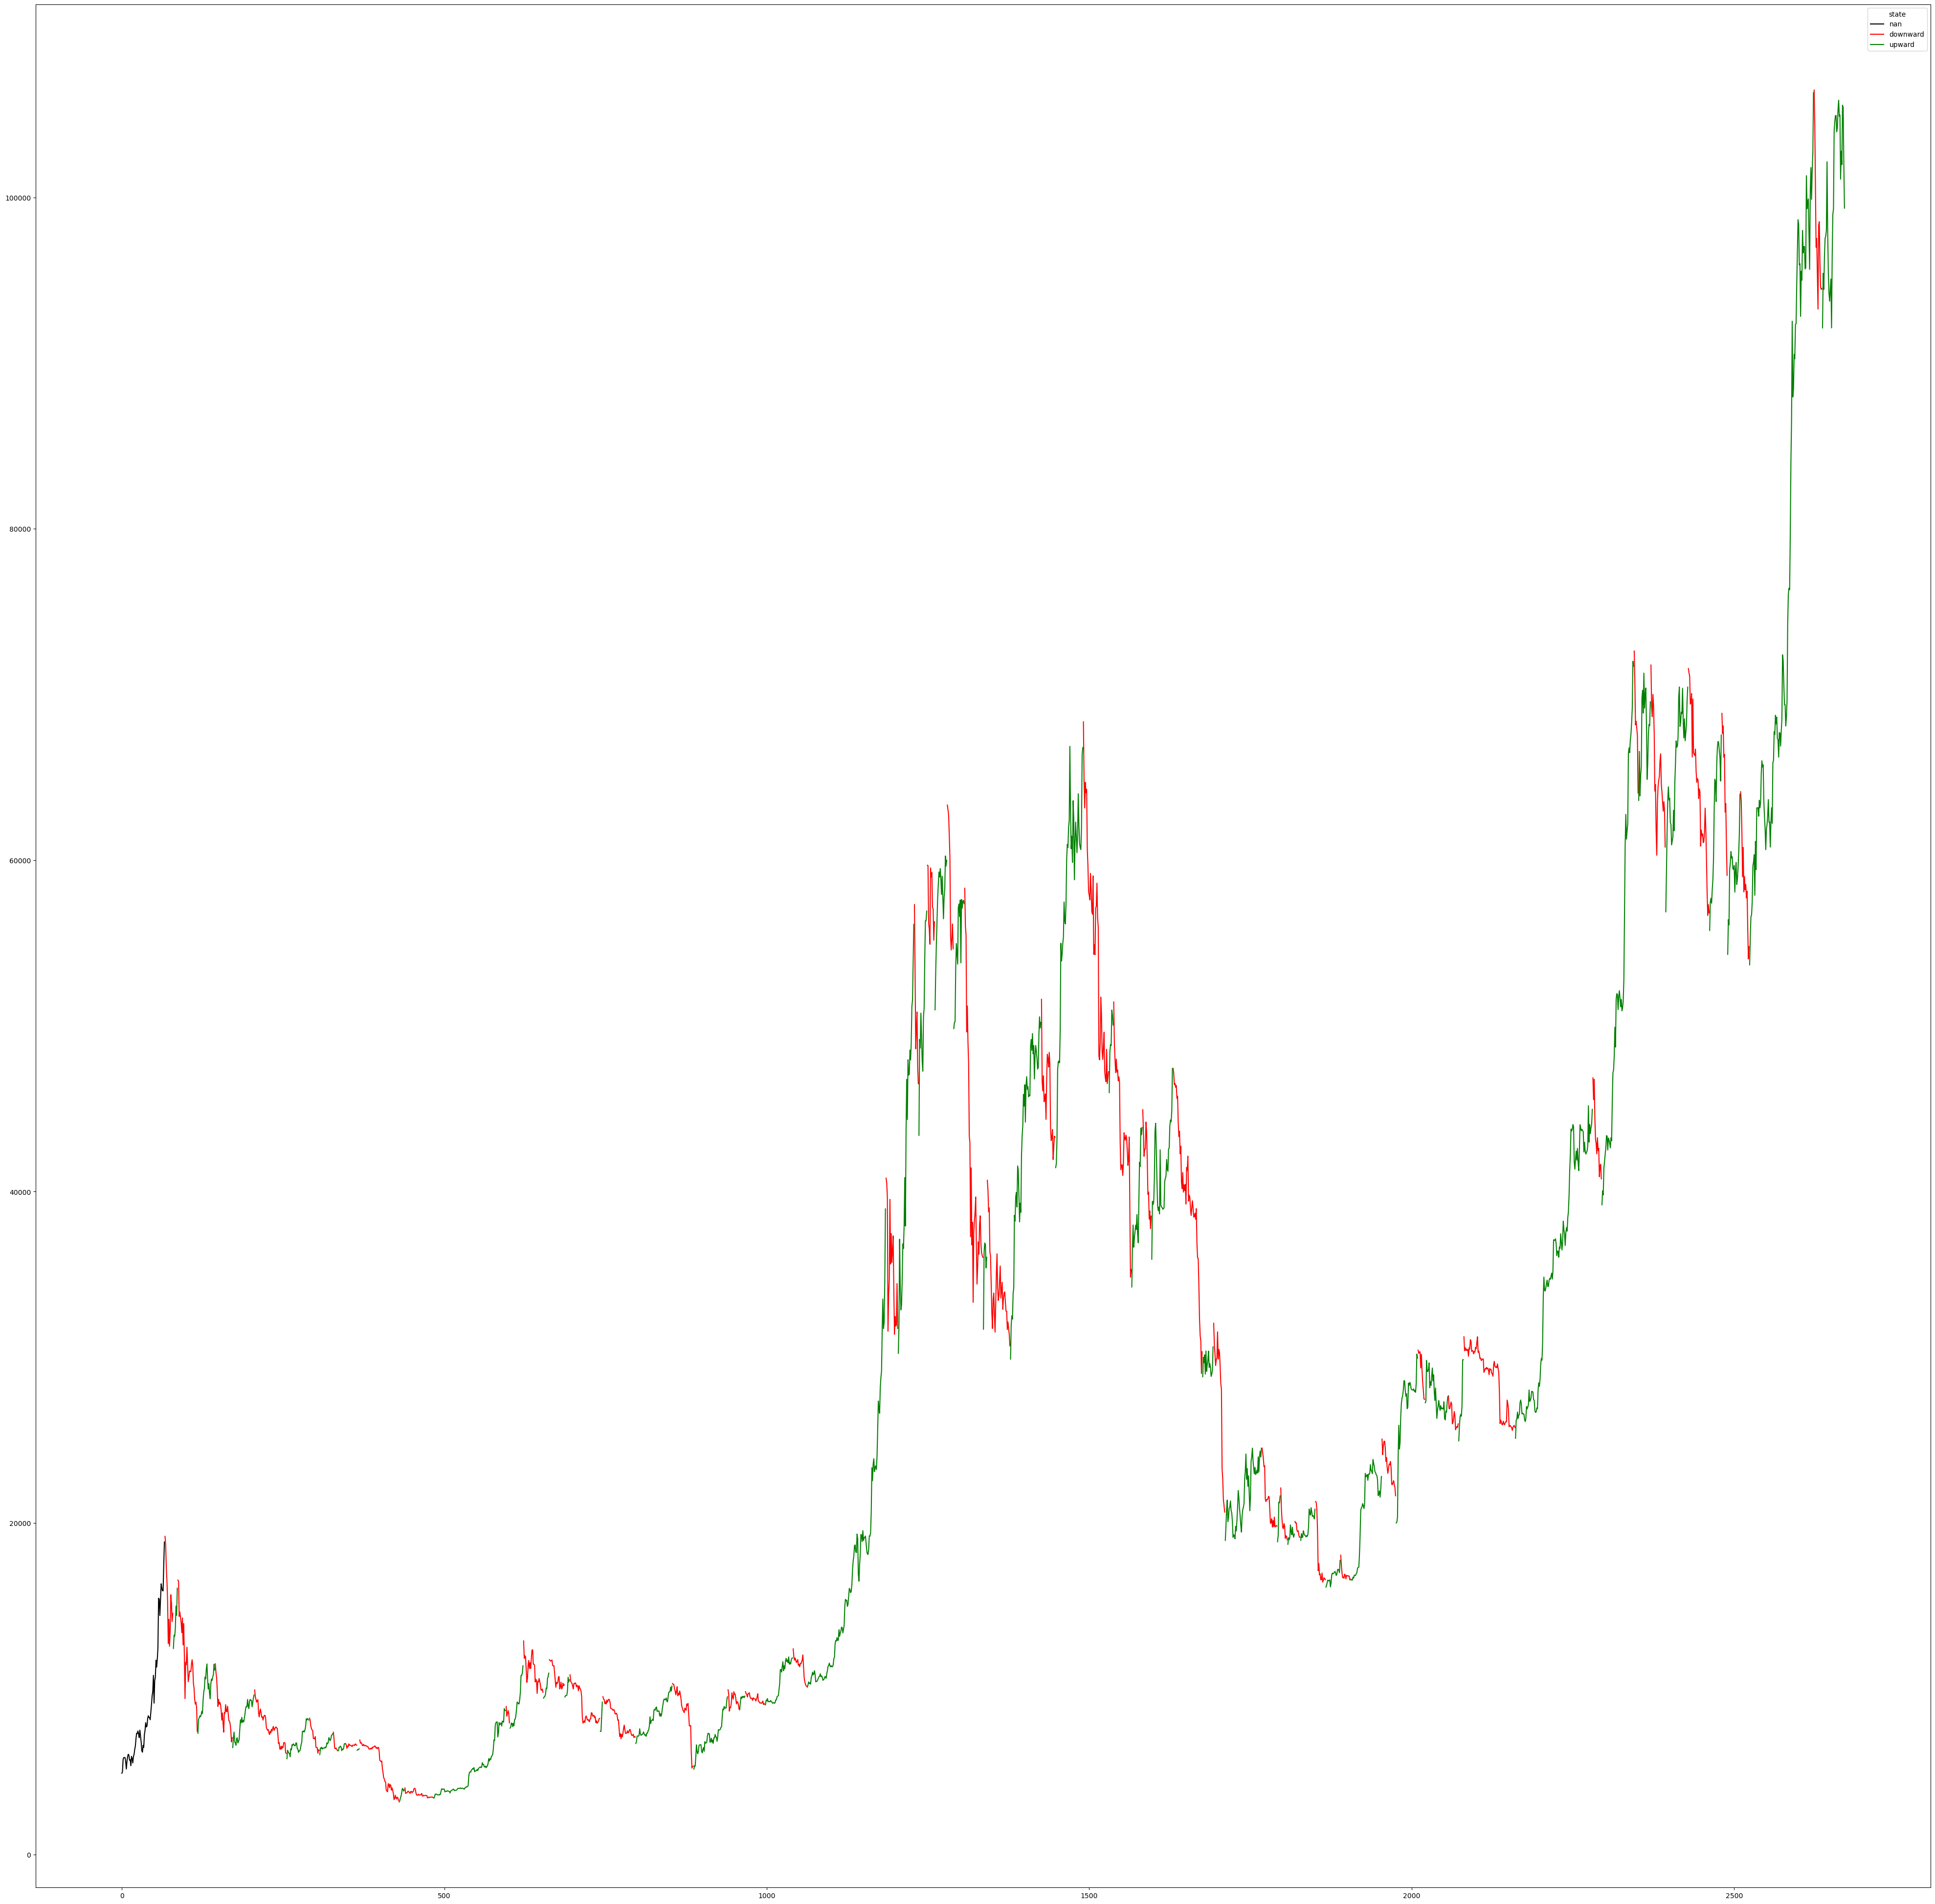

In [47]:
#deepseek

# Load data and preprocess
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')



# Load and preprocess data
#df = pd.read_csv('ohlc_data.csv').iloc[::-1].reset_index(drop=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Compute ATR30 for volatility scaling
df['prev_close'] = df['close'].shift(1)
df['TR'] = np.maximum(
    df['high'] - df['low'],
    np.abs(df['high'] - df['prev_close']),
    np.abs(df['low'] - df['prev_close'])
)
df['ATR30'] = df['TR'].rolling(30).mean()
df['threshold'] = 0.5 * df['ATR30']

# Find local minima/maxima (15-day window)
minima = argrelextrema(df['close'].values, np.less, order=15)[0]
maxima = argrelextrema(df['close'].values, np.greater, order=15)[0]
extrema = np.sort(np.concatenate([minima, maxima]))

# Label states between extrema
df['state'] = np.nan
for i in range(len(extrema) - 1):
    start, end = extrema[i], extrema[i + 1]
    if df['close'].iloc[start] < df['close'].iloc[end]:
        df.loc[start:end, 'state'] = 'upward'
    else:
        df.loc[start:end, 'state'] = 'downward'

# Label stable periods (price within threshold)
for i in range(len(df)):
    if pd.isna(df['state'].iloc[i]):
        window = df['close'].iloc[max(0, i-15):min(len(df), i+15)]
        if (df['close'].iloc[i] - df['threshold'].iloc[i] <= window.min()) and \
           (window.max() <= df['close'].iloc[i] + df['threshold'].iloc[i]):
            df.loc[i, 'state'] = 'stable'

# Forward-fill remaining NaNs (transient noise)
df['state'] = df['state'].ffill()

# Output
result = df[['timestamp', 'close', 'state']]
print(result)

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'b',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

    timestamp    open    high     low   close     volume     volume_ccy  \
0  10/10/2017     1.0  4901.0     1.0  4901.0  19.260000   94393.260000   
1  10/11/2017  4901.0  4999.0  4790.0  4989.0   0.580096    2894.098894   
2  10/12/2017  4989.0  5922.0  4989.0  5741.6  20.739843  119079.880800   
3  10/13/2017  5741.6  5849.9  5473.7  5849.9  19.259580  112666.617000   
4  10/14/2017  5849.9  5849.9  5686.4  5848.0   8.658607   50635.532620   

     volCcyQuote  
0   94393.260000  
1    2894.098894  
2  119079.880800  
3  112666.617000  
4   50635.532620  
       timestamp     close   state
15    10/25/2017    5920.0  upward
16    10/26/2017    5799.9  upward
17    10/27/2017    5521.8  upward
18    10/28/2017    5900.0  upward
19    10/29/2017    6041.2  upward
...          ...       ...     ...
2664   1/25/2025  104972.6  upward
2665   1/26/2025  101101.3  upward
2666   1/27/2025  102776.8  upward
2667   1/28/2025  101975.5  upward
2668   1/29/2025  105564.0  upward

[2378 rows x 3

<AxesSubplot:>

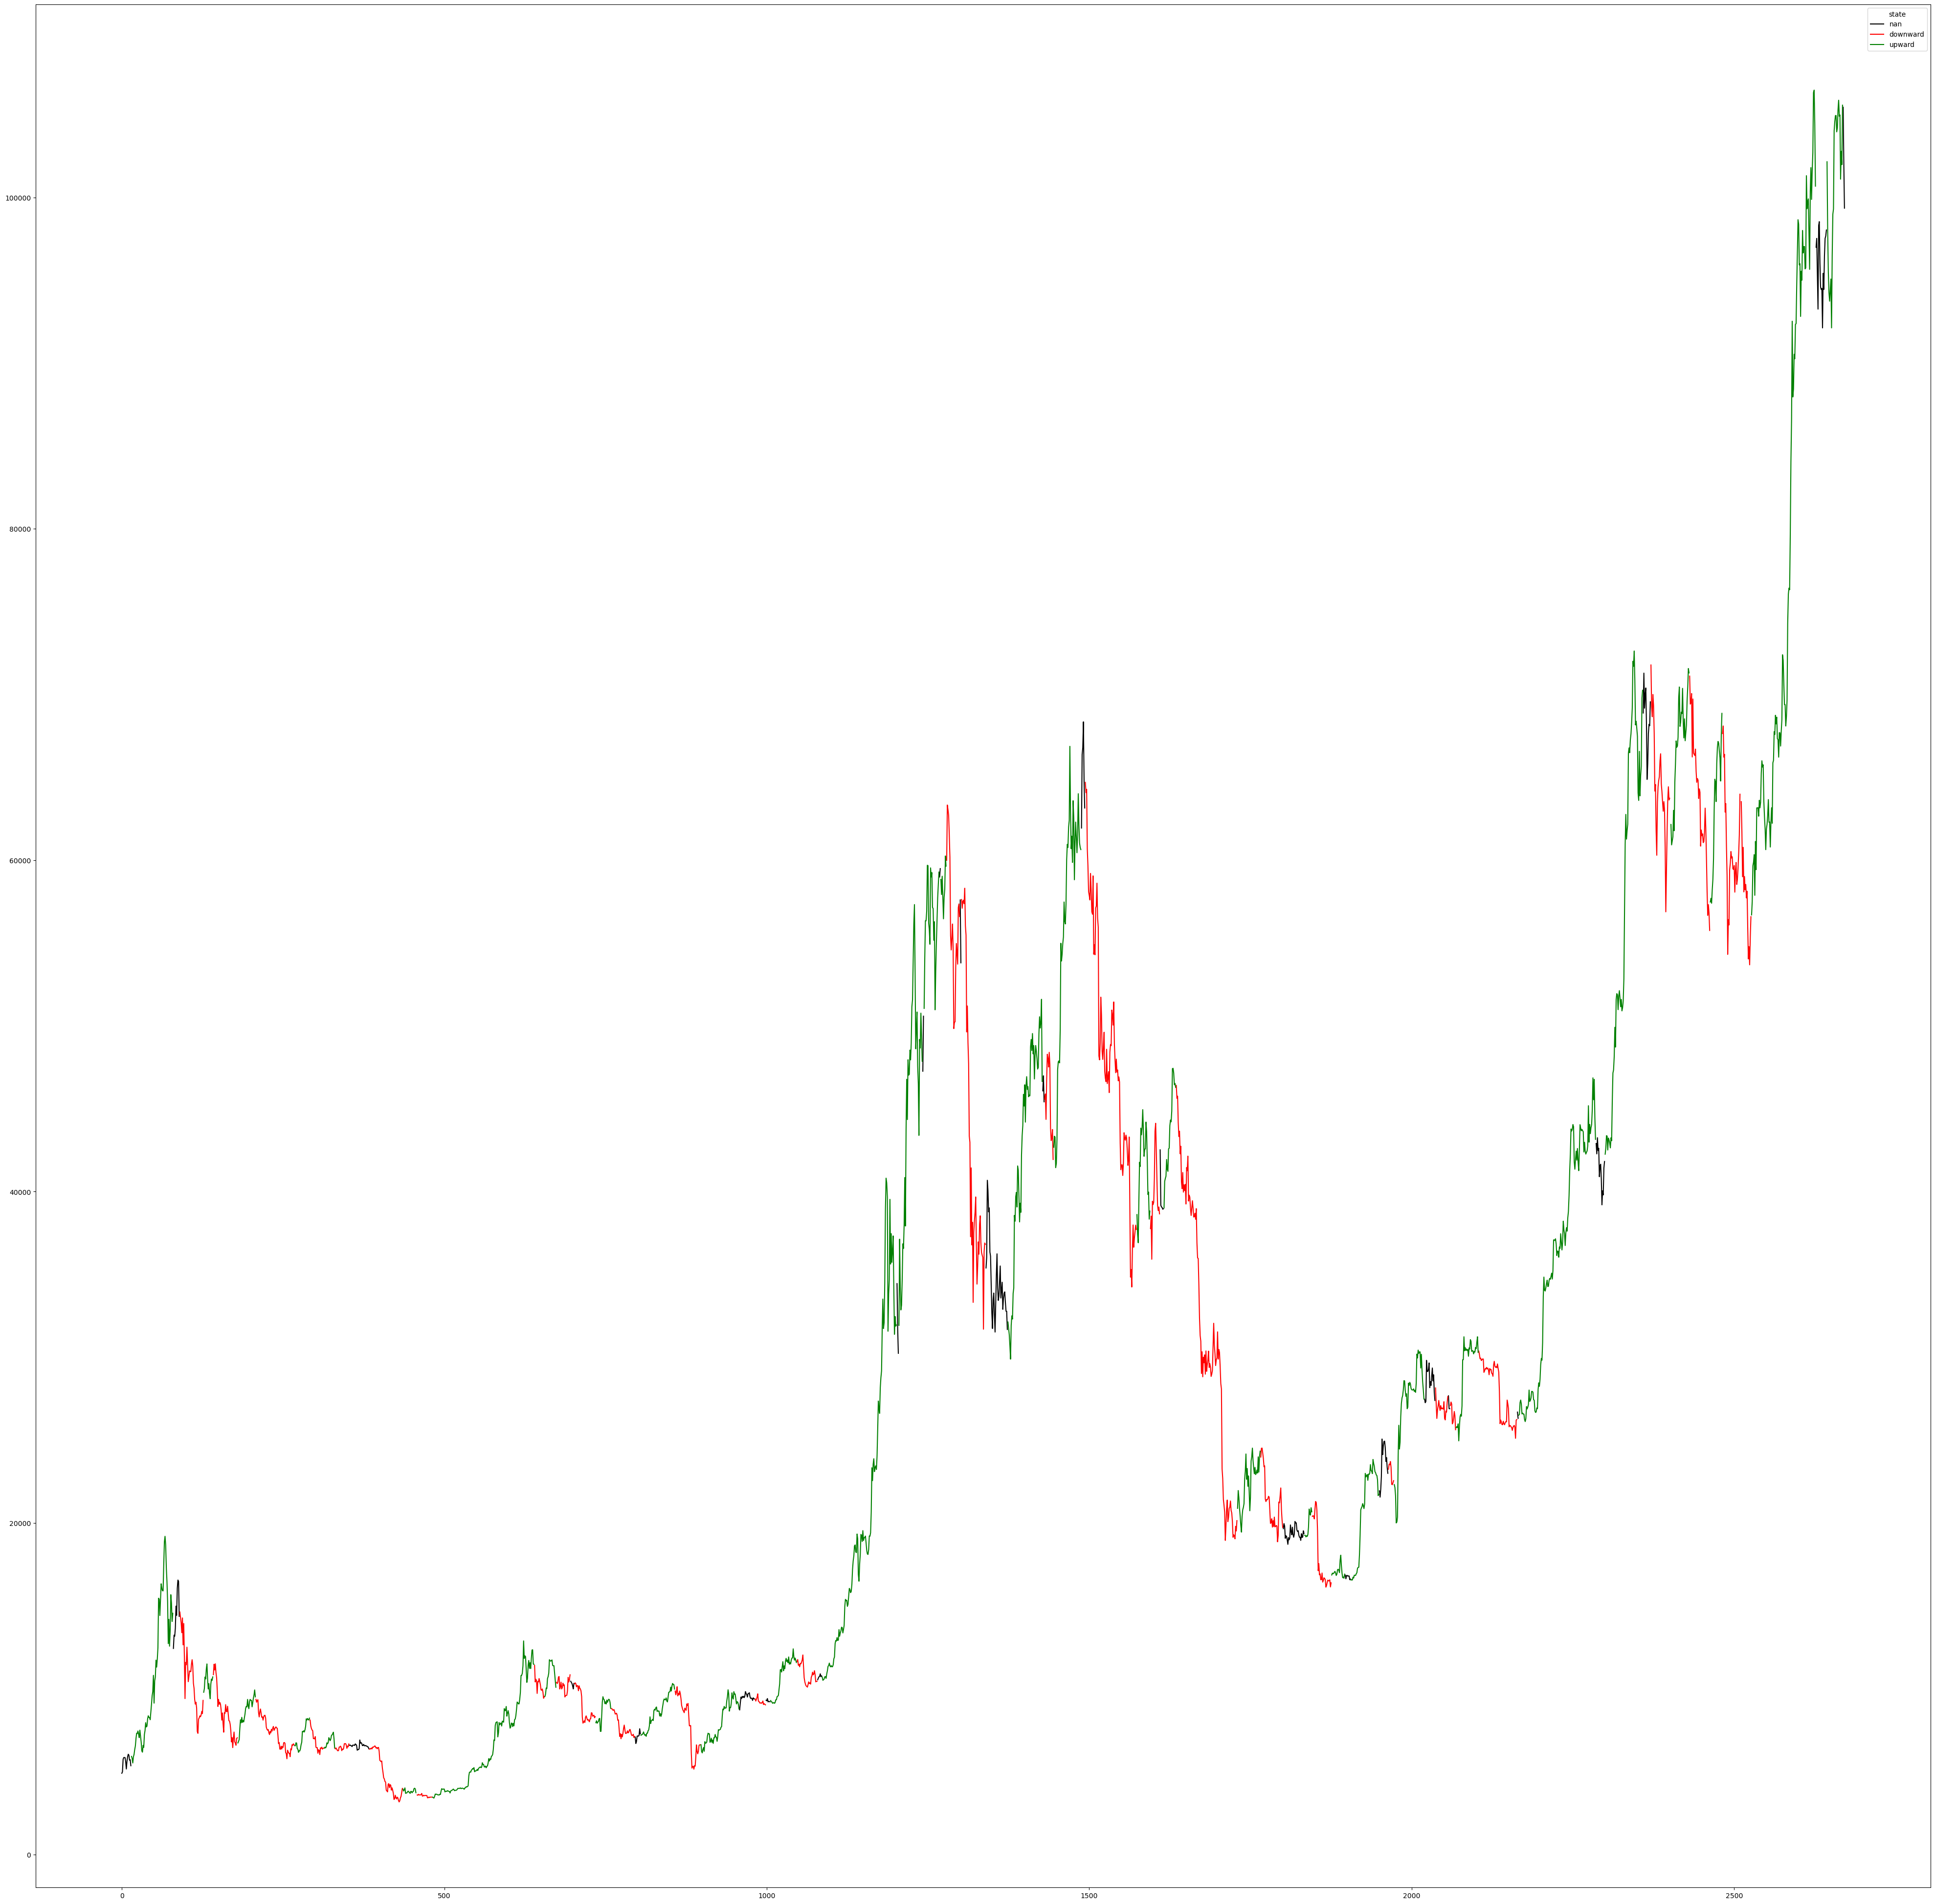

In [72]:
#greater focus on labeling flat/rangebound


#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')


def detect_market_states(df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5):
    """
    Detect market states (upward, downward, stable) with enhanced rangebound detection.
    """
    # Calculate technical indicators
    df['MA'] = df['close'].rolling(ma_window).mean()
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    
    # Initialize state column
    df['state'] = np.nan
    
    # Forward-looking window for analysis
    lookahead = window
    
    for i in range(len(df) - lookahead):
        current_window = df.iloc[i:i+lookahead]
        prices = current_window['close'].values
        
        # Find local extrema in the window
        minima = argrelextrema(prices, np.less, order=3)[0]
        maxima = argrelextrema(prices, np.greater, order=3)[0]
        
        # Rangebound detection criteria
        if len(minima) >= 2 and len(maxima) >= 2:  # At least 2 peaks and troughs
            # Check if extrema are at similar levels
            min_diff = np.std(prices[minima]) / df['ATR'].iloc[i]
            max_diff = np.std(prices[maxima]) / df['ATR'].iloc[i]
            
            # Check MA crosses (should cross between each extrema)
            ma_crosses = len(np.where(np.diff(np.sign(prices - current_window['MA'].values))[0]))
            
            # Check if long MA is relatively flat
            try:
                ma_slope, _, _, p_value, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            except:
                continue
            
            # Rangebound conditions
            if (min_diff < 0.5 and max_diff < 0.5 and 
                ma_crosses >= (len(minima) + len(maxima)) and 
                abs(ma_slope) < (df['ATR'].iloc[i]/ma_window) and 
                p_value > 0.05):
                
                df.loc[i:i+lookahead-1, 'state'] = 'stable'
                continue
        
        # Trend detection (only if not rangebound)
        full_window = df.iloc[max(0,i-window):i+lookahead]
        x = np.arange(len(full_window))
        slope, _, _, p_value, _ = linregress(x, full_window['close'])
        
        if slope > (df['ATR'].iloc[i]/window) and p_value < 0.05:
            df.loc[i:i+lookahead-1, 'state'] = 'upward'
        elif slope < -(df['ATR'].iloc[i]/window) and p_value < 0.05:
            df.loc[i:i+lookahead-1, 'state'] = 'downward'
    
    # Fill remaining gaps as stable if they meet volatility criteria
    for i in range(len(df)):
        if pd.isna(df['state'].iloc[i]):
            lookback = min(window, i)
            lookahead = min(window, len(df)-i-1)
            window_prices = df['close'].iloc[i-lookback:i+lookahead+1]
            if (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                df.loc[i, 'state'] = 'stable'
    
    return df

# Load and process data
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')

df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)

# Drop rows with all NaN values (if any)
df = df.dropna(how='all')

# Verify the data
print(df.head())

df['close'] = pd.to_numeric(df['close'], errors='coerce')
#df = detect_market_states(df)

df = detect_market_states(df, 15, 50, 15 ,0.5)
#df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5):

# Output results
result = df[['timestamp', 'close', 'state']].dropna()
print(result)


#graph
graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

       timestamp     close   state
20    10/30/2017    6335.0  upward
21    10/31/2017    6544.1  upward
22     11/1/2017    7000.0  upward
23     11/2/2017    7318.5  upward
24     11/3/2017    7299.0  upward
...          ...       ...     ...
2667   1/28/2025  101975.5  upward
2668   1/29/2025  105564.0  upward
2669   1/30/2025  105438.0  upward
2670   1/31/2025  102074.3  upward
2671    2/1/2025   99348.2  upward

[2652 rows x 3 columns]


<AxesSubplot:>

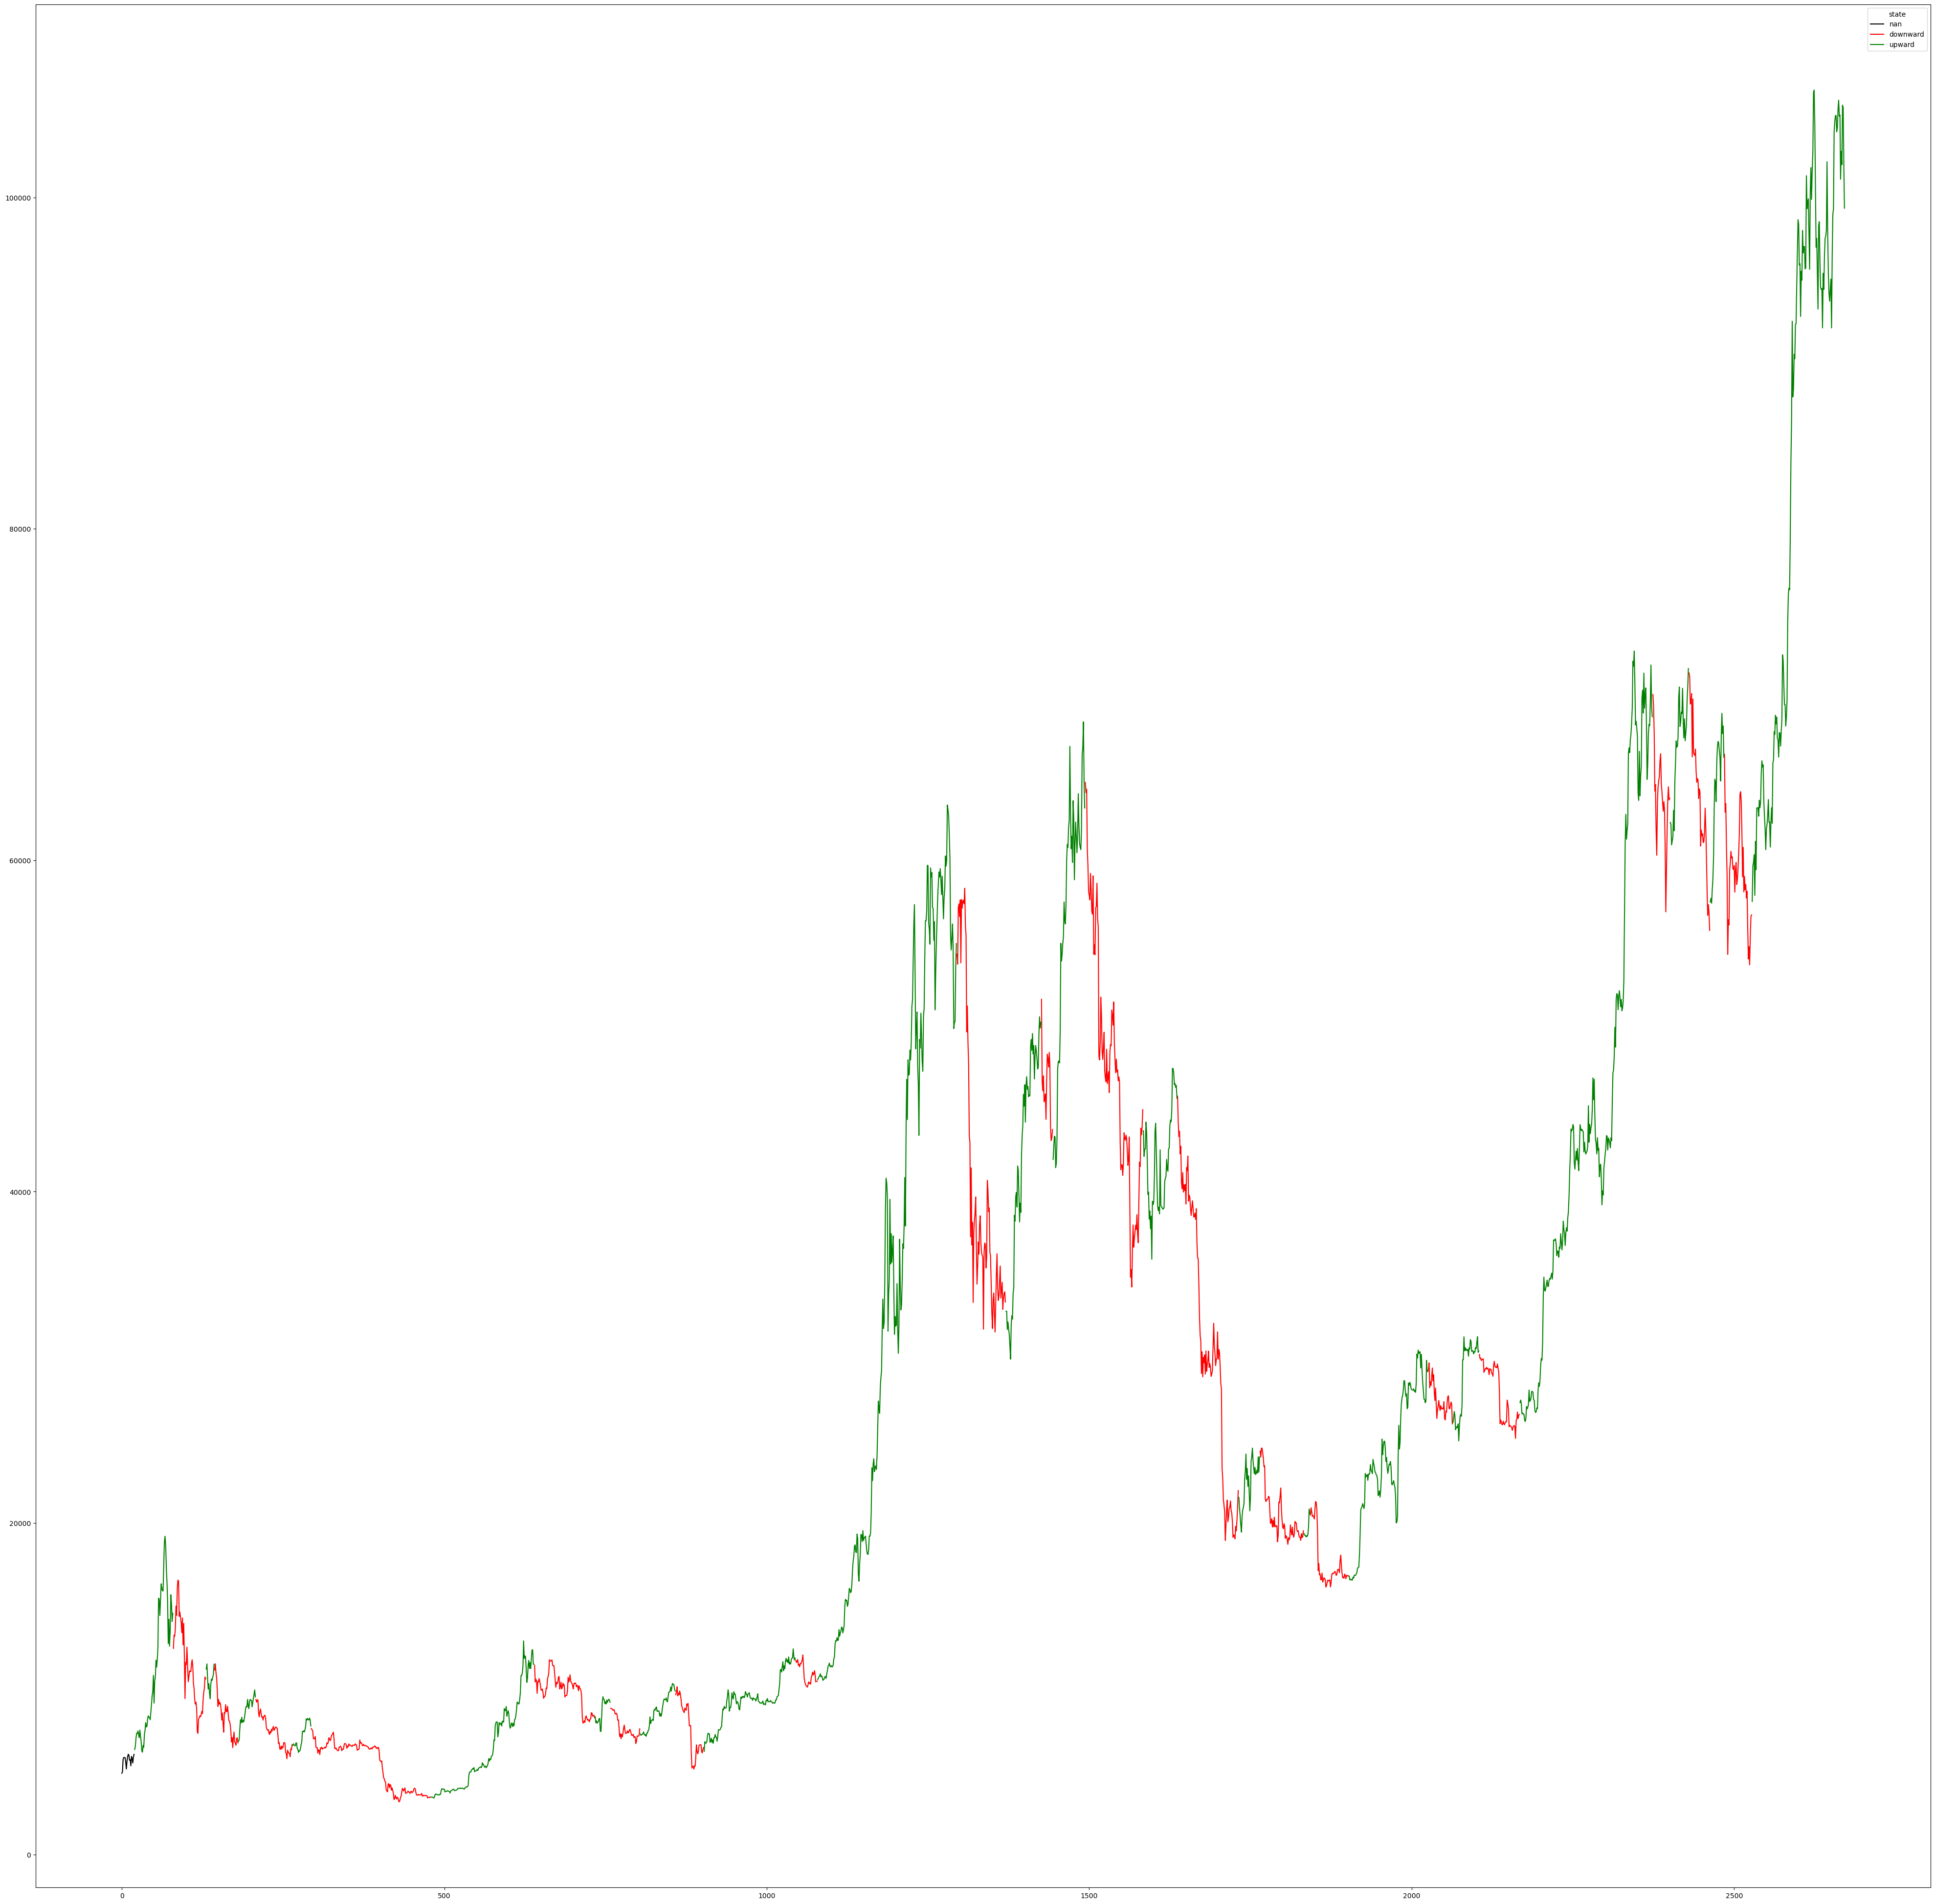

In [79]:
#tries to identify rangebound first, then trending

def detect_market_states2(df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5):
    """
    Detect market states (stable, upward, downward) with priority given to stable detection
    """
    # Calculate technical indicators
    df['MA'] = df['close'].rolling(ma_window).mean()
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['threshold'] = threshold_factor * df['ATR']
    df['rolling_std'] = df['close'].rolling(window).std()
    
    # Initialize state column
    df['state'] = np.nan
    
    # Forward-looking window for analysis
    lookahead = window
    
    for i in range(len(df) - lookahead):
        current_window = df.iloc[i:i+lookahead]
        prices = current_window['close'].values
        
        # First check for stable conditions
        is_stable = False
        
        # Find local extrema in the window
        minima = argrelextrema(prices, np.less, order=3)[0]
        maxima = argrelextrema(prices, np.greater, order=3)[0]
        
        # Rangebound detection criteria
        if len(minima) >= 2 and len(maxima) >= 2:  # At least 2 peaks and troughs
            # Check if extrema are at similar levels (within 0.5 ATR)
            min_diff = np.std(prices[minima]) / df['ATR'].iloc[i]
            max_diff = np.std(prices[maxima]) / df['ATR'].iloc[i]
            
            # Check MA crosses (should cross between each extrema)
            ma_crosses = len(np.where(np.diff(np.sign(prices - current_window['MA'].values)))[0])
            
            # Check if long MA is relatively flat
            try:
                ma_slope, _, _, ma_pvalue, _ = linregress(np.arange(ma_window), df['MA'].iloc[i:i+ma_window])
            except:
                continue
            
            # Check price oscillation within threshold
            price_range = prices.max() - prices.min()
            
            # Stable conditions
            if (min_diff < 0.5 and max_diff < 0.5 and ma_crosses >= (len(minima) + len(maxima)) and abs(ma_slope) < (df['ATR'].iloc[i]/ma_window) and ma_pvalue > 0.05 and price_range < df['threshold'].iloc[i]):
                
                df.loc[i:i+lookahead-1, 'state'] = 'stable'
                is_stable = True
        
        # Only check trends if not stable
        if not is_stable:
            full_window = df.iloc[max(0,i-window):i+lookahead]
            x = np.arange(len(full_window))
            slope, _, _, p_value, _ = linregress(x, full_window['close'])
            
            if slope > (df['ATR'].iloc[i]/window) and p_value < 0.05:
                df.loc[i:i+lookahead-1, 'state'] = 'upward'
            elif slope < -(df['ATR'].iloc[i]/window) and p_value < 0.05:
                df.loc[i:i+lookahead-1, 'state'] = 'downward'
    
    # Fill remaining gaps as stable if they meet volatility criteria
    for i in range(len(df)):
        if pd.isna(df['state'].iloc[i]):
            lookback = min(window, i)
            lookahead = min(window, len(df)-i-1)
            window_prices = df['close'].iloc[i-lookback:i+lookahead+1]
            if (window_prices.max() - window_prices.min()) < df['threshold'].iloc[i]:
                df.loc[i, 'state'] = 'stable'
    
    # Forward fill any remaining small gaps
    df['state'] = df['state'].ffill()
    
    return df

# Load and process data
df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = detect_market_states2(df, 20, 75, 20, 0.5)
#df, window=30, ma_window=50, atr_window=30, threshold_factor=0.5

# Output results
result = df[['timestamp', 'close', 'state']].dropna()
print(result)

graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)

<AxesSubplot:>

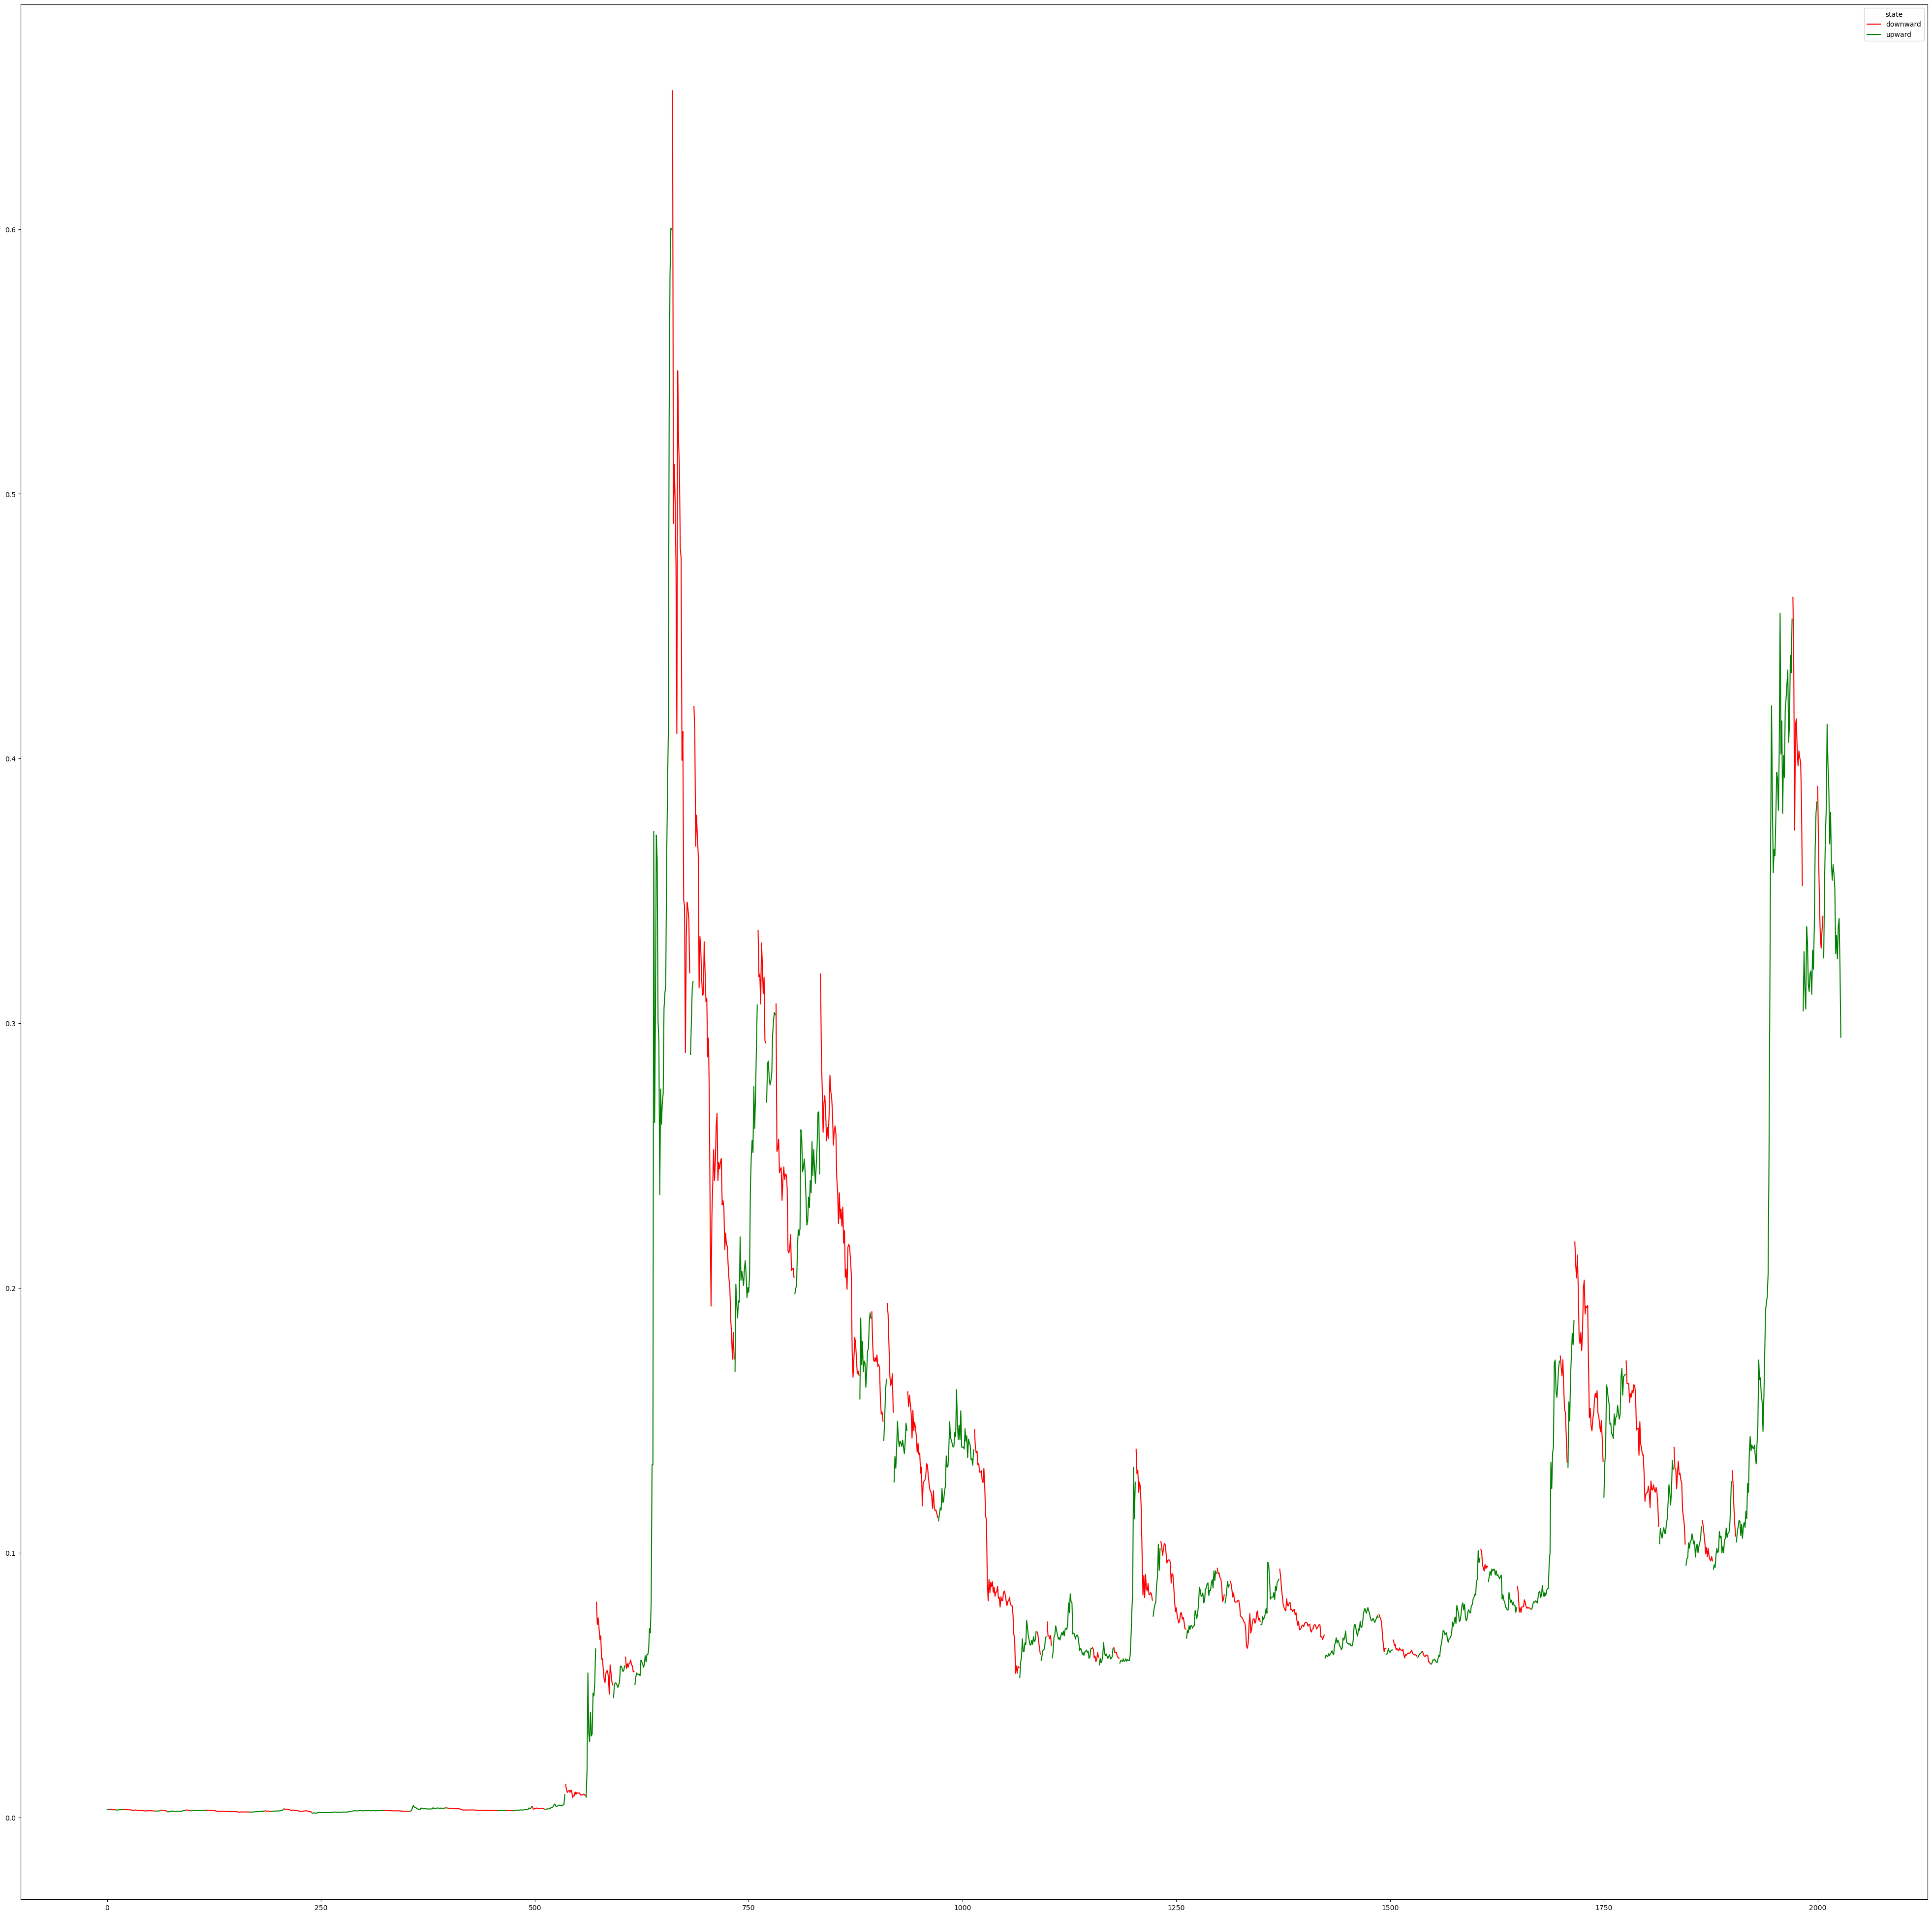

In [87]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from scipy.stats import linregress
from sklearn.cluster import DBSCAN

def detect_market_states(df, min_period=14, atr_window=14, volatility_factor=0.5):
    """
    Detect market states with dynamic window sizing and fuzzy period detection
    """
    # Calculate volatility-based thresholds
    df['prev_close'] = df['close'].shift(1)
    df['TR'] = np.maximum(
        df['high'] - df['low'],
        np.abs(df['high'] - df['prev_close']),
        np.abs(df['low'] - df['prev_close'])
    )
    df['ATR'] = df['TR'].rolling(atr_window).mean()
    df['threshold'] = volatility_factor * df['ATR']
    
    # Initialize state columns
    df['state'] = np.nan
    df['peak_valley'] = np.nan  # Track extrema
    
    # Find all significant extrema first
    minima = argrelextrema(df['close'].values, np.less, order=min_period)[0]
    maxima = argrelextrema(df['close'].values, np.greater, order=min_period)[0]
    
    # Cluster similar extrema using DBSCAN (fuzzy level matching)
    def cluster_extrema(extrema_values, eps=0.5):
        if len(extrema_values) < 2:
            return np.zeros(len(extrema_values))
        clustering = DBSCAN(eps=eps*extrema_values.std(), min_samples=2).fit(extrema_values.reshape(-1,1))
        return clustering.labels_
    
    # Process minima and maxima clusters
    df.loc[minima, 'peak_valley'] = -1  # Valleys
    df.loc[maxima, 'peak_valley'] = 1   # Peaks
    
    # Dynamic state assignment
    current_state = None
    state_start = 0
    
    for i in range(1, len(df)):
        # Check for state transitions
        if not np.isnan(df['peak_valley'].iloc[i]):
            # Get recent extrema cluster
            recent_extrema = df['peak_valley'].iloc[max(0,i-min_period):i+1]
            
            # Determine probable state
            if len(recent_extrema[recent_extrema == 1]) >= 2 and len(recent_extrema[recent_extrema == -1]) >= 2:
                # Potential stable period
                valley_prices = df.loc[recent_extrema[recent_extrema == -1].index, 'close']
                peak_prices = df.loc[recent_extrema[recent_extrema == 1].index, 'close']
                
                # Fuzzy similarity check
                if (valley_prices.std() < df['threshold'].iloc[i] and 
                    peak_prices.std() < df['threshold'].iloc[i]):
                    current_state = 'stable'
            
            elif df['peak_valley'].iloc[i] == 1:  # New peak
                current_state = 'upward'
            elif df['peak_valley'].iloc[i] == -1:  # New valley
                current_state = 'downward'
            
            # Apply state to entire period since last transition
            df.loc[state_start:i, 'state'] = current_state
            state_start = i
    
    # Post-processing to handle residual periods
    df['state'] = df['state'].ffill().bfill()
    
    # Validate states with rolling volatility
    for i in range(len(df)):
        if df['state'].iloc[i] == 'stable':
            lookback = min(3*min_period, i)
            window = df['close'].iloc[i-lookback:i+1]
            if window.max() - window.min() > 2*df['threshold'].iloc[i]:
                df.loc[i, 'state'] = df['state'].iloc[i-1]  # Revert to previous state
    
    return df

# Example usage
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_ds.csv', skip_blank_lines=True)
df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv', skip_blank_lines=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df = detect_market_states(df, min_period=10, atr_window=50, volatility_factor=0.9)
#s(df, min_period=14, atr_window=14, volatility_factor=0.5):

# Visualization
'''
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price', alpha=0.5)
plt.scatter(df.index, df['close'], c=df['state'].map({'upward':'green','downward':'red','stable':'blue'}), 
            label='State', alpha=0.7)
plt.title('Dynamic Market State Detection')
plt.legend()
plt.show()
'''
graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'blue',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)